
# Module 3 — Lesson 4: Practical Regularization Demo (PyTorch, Tiny Char Model)

This notebook demonstrates each theme from Lesson 4 in order, on a tiny **character-level next-token** model.
It runs offline and trains quickly on CPU.

**What you'll see (in order of the lesson):**
1. Spotting overfitting with a simple train/validation dashboard
2. Dropout as a gentle first fix
3. Weight decay (a small simplicity tax)
4. Label smoothing (dial down over-confidence)
5. Early stopping (quit while you're ahead)
6. Data-side regularization (clean and balance before knobs)
7. A safe starter recipe
8. Divergence triage (stabilize before tweaking)
9. Minimal run logging for clean comparisons

Runtime: a few minutes on CPU. Reduce `EPOCHS` if needed.


In [1]:

# Minimal setup
import math, time, random, os, sys
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt  # single-chart requirement
plt.rcParams.update({'figure.figsize': (6, 4)})

SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')


## 0) Tiny Corpus (with duplicates and noise)
We purposely include duplicates and some low-quality lines so we can show **data-side regularization** later.


In [2]:

raw_corpus = [
    "the quick brown fox jumps over the lazy dog",
    "the quick brown fox jumps over the lazy dog",  # duplicate
    "pack my box with five dozen liquor jugs",
    "sphinx of black quartz, judge my vow",
    "how razorback-jumping frogs can level six piqued gymnasts",
    "the five boxing wizards jump quickly",
    "lorem ipsum dolor sit amet sit amet amet",  # low-quality repetition
    "the quick brown fox jumps over the lazy dog",  # duplicate
    "bright vixens jump; dozy fowl quack",
    "quick wafting zephyrs vex bold jim",
    "crazy fredrick bought many very exquisite opal jewels",
]

print("Total lines:", len(raw_corpus))
print("\nSample:")
for s in raw_corpus[:3]:
    print("-", s)


Total lines: 11

Sample:
- the quick brown fox jumps over the lazy dog
- the quick brown fox jumps over the lazy dog
- pack my box with five dozen liquor jugs



## 1) Character-level Tokenization
Simple char vocab covers letters, punctuation, and spaces in this tiny dataset.


In [3]:

text = "\n".join(raw_corpus)
vocab = sorted(list(set(text)))
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for ch,i in stoi.items()}

def encode(s):
    return [stoi[c] for c in s]

def decode(ids):
    return "".join(itos[i] for i in ids)

vocab_size = len(vocab)
vocab_size


31


## 2) Dataset and Dataloaders
We train to predict the **next character** given a short context window.


In [4]:

CTX = 64  # small context
def build_sequences(text, ctx=CTX):
    ids = encode(text)
    X, Y = [], []
    for i in range(len(ids) - ctx):
        X.append(ids[i:i+ctx])
        Y.append(ids[i+ctx])
    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

X_all, Y_all = build_sequences(text, CTX)

# Train/Val split by contiguous blocks for simplicity
split = int(0.85 * len(X_all))
Xtr, Ytr = X_all[:split], Y_all[:split]
Xva, Yva = X_all[split:], Y_all[split:]

class CharDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X; self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

BATCH = 64
train_loader = DataLoader(CharDataset(Xtr, Ytr), batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(CharDataset(Xva, Yva), batch_size=BATCH, shuffle=False)

len(train_loader), len(val_loader)


(6, 1)


## 3) Tiny Model
A minimal character model:
- Embedding layer
- A small GRU with configurable **dropout**
- A linear head to predict the next char


In [5]:

class TinyCharModel(nn.Module):
    def __init__(self, vocab_size, emb=64, hid=128, dropout=0.0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb)
        self.gru = nn.GRU(emb, hid, batch_first=True, dropout=dropout if 1>1 else 0.0)  # GRU uses dropout only if num_layers>1
        # make a 2-layer GRU to activate dropout
        self.gru = nn.GRU(emb, hid, num_layers=2, batch_first=True, dropout=dropout)
        self.head = nn.Linear(hid, vocab_size)

    def forward(self, x):
        x = self.embed(x)                 # (B, T, E)
        out, _ = self.gru(x)              # (B, T, H)
        logits = self.head(out[:, -1, :]) # take last step
        return logits

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)



## 4) Label Smoothing Loss
We replace the one-hot target with a slightly softened distribution.


In [6]:

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0):
        super().__init__()
        self.classes = classes
        self.smoothing = smoothing

    def forward(self, logits, target):
        # logits: (B, C), target: (B,)
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (self.classes))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing + (self.smoothing / self.classes))
        log_probs = torch.log_softmax(logits, dim=-1)
        loss = -(true_dist * log_probs).sum(dim=-1).mean()
        return loss



## 5) Training Utilities (Early Stopping, Clipping, Logging)
We implement:
- Early stopping with patience
- Optional gradient clipping
- Minimal logging: train/val loss, perplexity, tokens/sec, and the regularization settings


In [7]:

class EarlyStopper:
    def __init__(self, patience=3):
        self.patience = patience
        self.best = float('inf')
        self.count = 0
        self.best_state = None

    def step(self, val_loss, model):
        if val_loss < self.best - 1e-6:
            self.best = val_loss
            self.count = 0
            self.best_state = {k: v.clone() for k, v in model.state_dict().items()}
            return False, True  # stop?, improved?
        else:
            self.count += 1
            return self.count >= self.patience, False

def run_epoch(model, loader, criterion, optimizer=None, clip_grad=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, total_tokens = 0.0, 0
    start = time.time()
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        logits = model(X)
        loss = criterion(logits, Y)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
        total_loss += loss.item() * X.size(0)
        total_tokens += X.size(0)
    dt = time.time() - start
    avg_loss = total_loss / max(1, total_tokens)
    ppl = math.exp(avg_loss) if avg_loss < 20 else float('inf')
    tps = (total_tokens * X.size(1)) / max(1e-9, dt)
    return avg_loss, ppl, tps

def train_run(config):
    torch.manual_seed(config.get('seed', 42))
    model = TinyCharModel(vocab_size, emb=64, hid=128, dropout=config.get('dropout', 0.0)).to(device)

    criterion = LabelSmoothingLoss(vocab_size, smoothing=config.get('label_smoothing', 0.0))
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.get('lr', 3e-3), weight_decay=config.get('weight_decay', 0.0))

    early = EarlyStopper(patience=config.get('patience', 3))
    EPOCHS = config.get('epochs', 10)
    clip = config.get('clip_grad', None)

    log = {'config': config, 'history': []}
    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_ppl, tr_tps = run_epoch(model, train_loader, criterion, optimizer, clip_grad=clip)
        va_loss, va_ppl, va_tps = run_epoch(model, val_loader, criterion, optimizer=None)

        log['history'].append({
            'epoch': epoch,
            'train_loss': tr_loss, 'train_ppl': tr_ppl, 'train_tps': tr_tps,
            'val_loss': va_loss, 'val_ppl': va_ppl, 'val_tps': va_tps
        })

        stop, improved = early.step(va_loss, model)
        print(f"Epoch {epoch:02d} | train_loss {tr_loss:.3f} | val_loss {va_loss:.3f} | val_ppl {va_ppl:.2f}")
        if stop:
            print("Early stopping triggered.")
            break

    # restore best
    if early.best_state is not None:
        model.load_state_dict(early.best_state)

    return model, log



## 6) Baseline Run — Spotting Overfitting
We begin with **no dropout**, **no weight decay**, **no label smoothing**, and **early stopping** enabled.


Epoch 01 | train_loss 3.367 | val_loss 3.203 | val_ppl 24.61
Epoch 02 | train_loss 3.070 | val_loss 3.124 | val_ppl 22.75
Epoch 03 | train_loss 2.807 | val_loss 3.071 | val_ppl 21.56
Epoch 04 | train_loss 2.492 | val_loss 3.060 | val_ppl 21.32
Epoch 05 | train_loss 2.152 | val_loss 3.131 | val_ppl 22.89
Epoch 06 | train_loss 1.837 | val_loss 3.241 | val_ppl 25.55
Epoch 07 | train_loss 1.549 | val_loss 3.296 | val_ppl 27.01
Early stopping triggered.


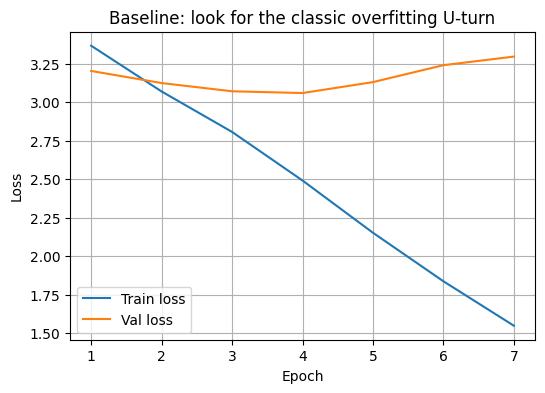

In [8]:

baseline_cfg = dict(seed=42, epochs=12, lr=3e-3, dropout=0.0, weight_decay=0.0, label_smoothing=0.0, patience=3, clip_grad=None)
base_model, base_log = train_run(baseline_cfg)

# Plot train vs val loss
train_losses = [h['train_loss'] for h in base_log['history']]
val_losses = [h['val_loss']   for h in base_log['history']]

plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val loss")
plt.title("Baseline: look for the classic overfitting U-turn")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 7) Dropout as a First Fix
Apply a small dropout and compare validation.


Epoch 01 | train_loss 3.367 | val_loss 3.203 | val_ppl 24.59
Epoch 02 | train_loss 3.082 | val_loss 3.127 | val_ppl 22.80
Epoch 03 | train_loss 2.838 | val_loss 3.082 | val_ppl 21.81
Epoch 04 | train_loss 2.544 | val_loss 3.105 | val_ppl 22.30
Epoch 05 | train_loss 2.210 | val_loss 3.125 | val_ppl 22.76
Epoch 06 | train_loss 1.901 | val_loss 3.204 | val_ppl 24.63
Early stopping triggered.


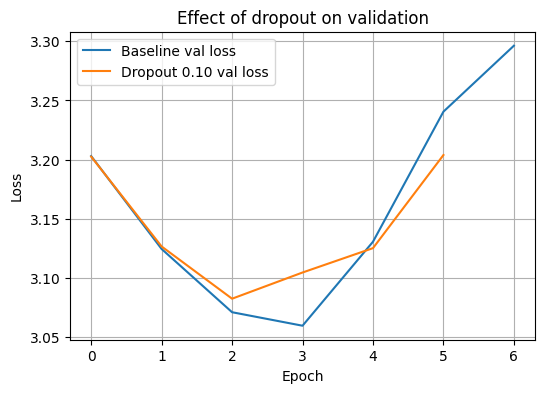

In [9]:

drop_cfg = dict(seed=42, epochs=12, lr=3e-3, dropout=0.10, weight_decay=0.0, label_smoothing=0.0, patience=3, clip_grad=None)
drop_model, drop_log = train_run(drop_cfg)

plt.figure()
plt.plot([h['val_loss'] for h in base_log['history']], label="Baseline val loss")
plt.plot([h['val_loss'] for h in drop_log['history']], label="Dropout 0.10 val loss")
plt.title("Effect of dropout on validation")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 8) Weight Decay (Small Sweep)
Try a small sweep: 0.00 (baseline), 0.01, 0.02.


Epoch 01 | train_loss 3.367 | val_loss 3.203 | val_ppl 24.61
Epoch 02 | train_loss 3.070 | val_loss 3.124 | val_ppl 22.75
Epoch 03 | train_loss 2.807 | val_loss 3.071 | val_ppl 21.56
Epoch 04 | train_loss 2.492 | val_loss 3.060 | val_ppl 21.32
Epoch 05 | train_loss 2.152 | val_loss 3.131 | val_ppl 22.89
Epoch 06 | train_loss 1.837 | val_loss 3.241 | val_ppl 25.55
Epoch 07 | train_loss 1.549 | val_loss 3.296 | val_ppl 27.01
Early stopping triggered.
Epoch 01 | train_loss 3.367 | val_loss 3.203 | val_ppl 24.61
Epoch 02 | train_loss 3.070 | val_loss 3.125 | val_ppl 22.75
Epoch 03 | train_loss 2.808 | val_loss 3.071 | val_ppl 21.56
Epoch 04 | train_loss 2.492 | val_loss 3.059 | val_ppl 21.31
Epoch 05 | train_loss 2.154 | val_loss 3.130 | val_ppl 22.88
Epoch 06 | train_loss 1.839 | val_loss 3.240 | val_ppl 25.53
Epoch 07 | train_loss 1.551 | val_loss 3.295 | val_ppl 26.98
Early stopping triggered.
Epoch 01 | train_loss 3.367 | val_loss 3.203 | val_ppl 24.61
Epoch 02 | train_loss 3.070 | val

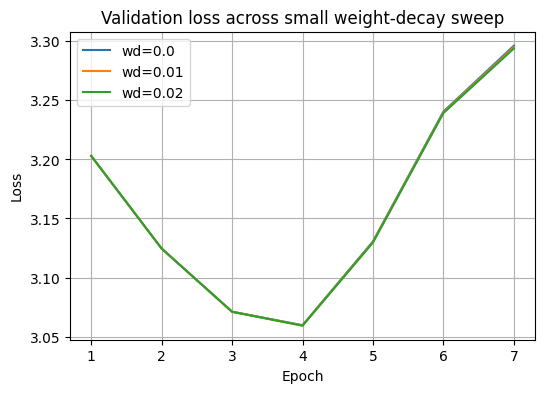

In [10]:

decay_results = {}
for wd in [0.0, 0.01, 0.02]:
    cfg = dict(seed=42, epochs=12, lr=3e-3, dropout=0.0, weight_decay=wd, label_smoothing=0.0, patience=3, clip_grad=None)
    _, log = train_run(cfg)
    decay_results[wd] = log

plt.figure()
for wd, log in decay_results.items():
    vals = [h['val_loss'] for h in log['history']]
    plt.plot(range(1, len(vals)+1), vals, label=f"wd={wd}")
plt.title("Validation loss across small weight-decay sweep")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 9) Label Smoothing (Tiny Values)
Start tiny (0.05), then 0.10 if needed.


Epoch 01 | train_loss 3.367 | val_loss 3.203 | val_ppl 24.61
Epoch 02 | train_loss 3.070 | val_loss 3.125 | val_ppl 22.75
Epoch 03 | train_loss 2.808 | val_loss 3.071 | val_ppl 21.56
Epoch 04 | train_loss 2.492 | val_loss 3.059 | val_ppl 21.31
Epoch 05 | train_loss 2.154 | val_loss 3.130 | val_ppl 22.88
Epoch 06 | train_loss 1.839 | val_loss 3.240 | val_ppl 25.53
Epoch 07 | train_loss 1.551 | val_loss 3.295 | val_ppl 26.98
Early stopping triggered.
Epoch 01 | train_loss 3.372 | val_loss 3.224 | val_ppl 25.12
Epoch 02 | train_loss 3.096 | val_loss 3.153 | val_ppl 23.42
Epoch 03 | train_loss 2.851 | val_loss 3.109 | val_ppl 22.41
Epoch 04 | train_loss 2.559 | val_loss 3.106 | val_ppl 22.32
Epoch 05 | train_loss 2.247 | val_loss 3.182 | val_ppl 24.10
Epoch 06 | train_loss 1.962 | val_loss 3.286 | val_ppl 26.73
Epoch 07 | train_loss 1.702 | val_loss 3.338 | val_ppl 28.15
Early stopping triggered.
Epoch 01 | train_loss 3.378 | val_loss 3.244 | val_ppl 25.63
Epoch 02 | train_loss 3.122 | val

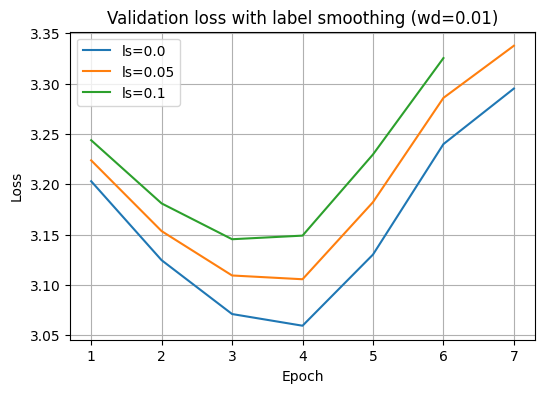

In [11]:

ls_results = {}
for ls in [0.0, 0.05, 0.10]:
    cfg = dict(seed=42, epochs=12, lr=3e-3, dropout=0.0, weight_decay=0.01, label_smoothing=ls, patience=3, clip_grad=None)
    _, log = train_run(cfg)
    ls_results[ls] = log

plt.figure()
for ls, log in ls_results.items():
    vals = [h['val_loss'] for h in log['history']]
    plt.plot(range(1, len(vals)+1), vals, label=f"ls={ls}")
plt.title("Validation loss with label smoothing (wd=0.01)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 10) Early Stopping (Patience)
We already used patience=3. Let's compare patience values.


Epoch 01 | train_loss 3.372 | val_loss 3.224 | val_ppl 25.12
Epoch 02 | train_loss 3.096 | val_loss 3.153 | val_ppl 23.42
Epoch 03 | train_loss 2.851 | val_loss 3.109 | val_ppl 22.41
Epoch 04 | train_loss 2.559 | val_loss 3.106 | val_ppl 22.32
Epoch 05 | train_loss 2.247 | val_loss 3.182 | val_ppl 24.10
Epoch 06 | train_loss 1.962 | val_loss 3.286 | val_ppl 26.73
Early stopping triggered.
Epoch 01 | train_loss 3.372 | val_loss 3.224 | val_ppl 25.12
Epoch 02 | train_loss 3.096 | val_loss 3.153 | val_ppl 23.42
Epoch 03 | train_loss 2.851 | val_loss 3.109 | val_ppl 22.41
Epoch 04 | train_loss 2.559 | val_loss 3.106 | val_ppl 22.32
Epoch 05 | train_loss 2.247 | val_loss 3.182 | val_ppl 24.10
Epoch 06 | train_loss 1.962 | val_loss 3.286 | val_ppl 26.73
Epoch 07 | train_loss 1.702 | val_loss 3.338 | val_ppl 28.15
Early stopping triggered.
Epoch 01 | train_loss 3.372 | val_loss 3.224 | val_ppl 25.12
Epoch 02 | train_loss 3.096 | val_loss 3.153 | val_ppl 23.42
Epoch 03 | train_loss 2.851 | val

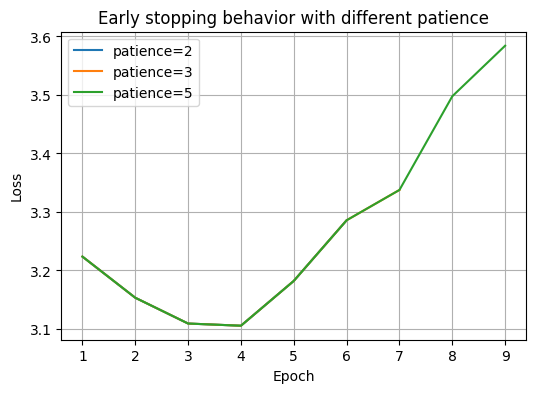

In [12]:

pat_results = {}
for pat in [2, 3, 5]:
    cfg = dict(seed=42, epochs=18, lr=3e-3, dropout=0.0, weight_decay=0.01, label_smoothing=0.05, patience=pat, clip_grad=None)
    _, log = train_run(cfg)
    pat_results[pat] = log

plt.figure()
for pat, log in pat_results.items():
    vals = [h['val_loss'] for h in log['history']]
    plt.plot(range(1, len(vals)+1), vals, label=f"patience={pat}")
plt.title("Early stopping behavior with different patience")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 11) Data-Side Regularization (Clean & Balance)
Remove near duplicates and cap the low-quality line to 1 occurrence; rebuild dataset and re-run a short training.


Original lines: 11 Cleaned lines: 9
[clean=False] epoch 1 val_loss 3.222
[clean=False] epoch 2 val_loss 3.123
[clean=False] epoch 3 val_loss 3.084
[clean=False] epoch 4 val_loss 3.082
[clean=False] epoch 5 val_loss 3.130
[clean=True] epoch 1 val_loss 3.208
[clean=True] epoch 2 val_loss 3.166
[clean=True] epoch 3 val_loss 3.088
[clean=True] epoch 4 val_loss 3.029
[clean=True] epoch 5 val_loss 3.039


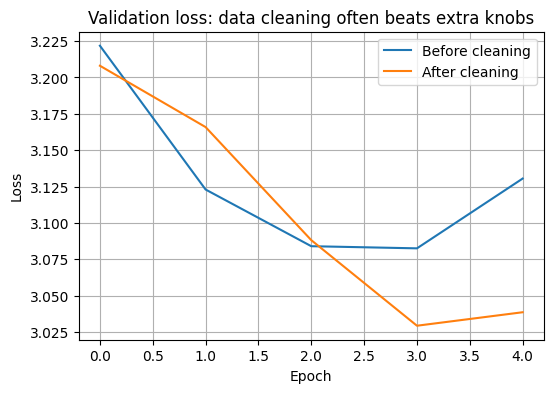

In [13]:

def clean_corpus(lines):
    seen = set()
    cleaned = []
    low_quality_marker = "lorem ipsum"
    low_count = 0
    for line in lines:
        key = line.strip().lower()
        if key.startswith(low_quality_marker):
            if low_count >= 1:
                continue
            low_count += 1
        if key in seen:
            continue
        seen.add(key)
        cleaned.append(line)
    return cleaned

cleaned = clean_corpus(raw_corpus)
print("Original lines:", len(raw_corpus), "Cleaned lines:", len(cleaned))

# rebuild dataset
clean_text = "\n".join(cleaned)
X_all2, Y_all2 = (lambda t: (torch.tensor([encode(t)[i:i+CTX] for i in range(len(encode(t))-CTX)]),
                              torch.tensor([encode(t)[i+CTX] for i in range(len(encode(t))-CTX)])))(clean_text)
split = int(0.85 * len(X_all2))
Xtr2, Ytr2 = X_all2[:split], Y_all2[:split]
Xva2, Yva2 = X_all2[split:], Y_all2[split:]

train_loader2 = DataLoader(CharDataset(Xtr2, Ytr2), batch_size=BATCH, shuffle=True)
val_loader2   = DataLoader(CharDataset(Xva2, Yva2), batch_size=BATCH, shuffle=False)

# short run
def run_epoch2(model, loader, criterion, optimizer=None, clip_grad=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, total_tokens = 0.0, 0
    start = time.time()
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        logits = model(X)
        loss = criterion(logits, Y)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
        total_loss += loss.item() * X.size(0)
        total_tokens += X.size(0)
    dt = time.time() - start
    avg_loss = total_loss / max(1, total_tokens)
    ppl = math.exp(avg_loss) if avg_loss < 20 else float('inf')
    return avg_loss, ppl

def short_train(clean_flag=True):
    model = TinyCharModel(vocab_size, dropout=0.10).to(device)
    crit = LabelSmoothingLoss(vocab_size, smoothing=0.05)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.01)
    loader_tr = train_loader2 if clean_flag else train_loader
    loader_va = val_loader2   if clean_flag else val_loader

    best = float('inf')
    val_hist = []
    for epoch in range(5):
        tr_loss, tr_ppl = run_epoch2(model, loader_tr, crit, opt)
        va_loss, va_ppl = run_epoch2(model, loader_va, crit, None)
        val_hist.append(va_loss)
        print(f"[clean={clean_flag}] epoch {epoch+1} val_loss {va_loss:.3f}")
        best = min(best, va_loss)
    return val_hist

val_dirty = short_train(clean_flag=False)
val_clean = short_train(clean_flag=True)

plt.figure()
plt.plot(val_dirty, label="Before cleaning")
plt.plot(val_clean, label="After cleaning")
plt.title("Validation loss: data cleaning often beats extra knobs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 12) A Safe Starter Recipe (All Together)
Small dropout, modest decay, tiny smoothing, early stopping.


Epoch 01 | train_loss 3.372 | val_loss 3.223 | val_ppl 25.11
Epoch 02 | train_loss 3.107 | val_loss 3.155 | val_ppl 23.46
Epoch 03 | train_loss 2.879 | val_loss 3.118 | val_ppl 22.60
Epoch 04 | train_loss 2.607 | val_loss 3.149 | val_ppl 23.30
Epoch 05 | train_loss 2.300 | val_loss 3.174 | val_ppl 23.91
Epoch 06 | train_loss 2.019 | val_loss 3.253 | val_ppl 25.86
Early stopping triggered.


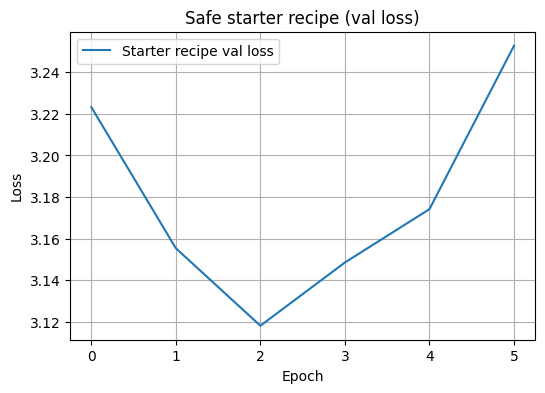

In [14]:

starter_cfg = dict(seed=42, epochs=15, lr=3e-3, dropout=0.10, weight_decay=0.01, label_smoothing=0.05, patience=3, clip_grad=None)
starter_model, starter_log = train_run(starter_cfg)

plt.figure()
plt.plot([h['val_loss'] for h in starter_log['history']], label="Starter recipe val loss")
plt.title("Safe starter recipe (val loss)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 13) Divergence Triage (Stabilize Before Tweaks)
Simulate instability and then fix it with LR ↓ and gradient clipping.


Epoch 01 | train_loss 6.116 | val_loss 8.397 | val_ppl 4431.97
Epoch 02 | train_loss 9.888 | val_loss 8.933 | val_ppl 7578.61
Epoch 03 | train_loss 9.246 | val_loss 7.487 | val_ppl 1784.37
Epoch 04 | train_loss 7.125 | val_loss 6.407 | val_ppl 606.30
Epoch 05 | train_loss 5.464 | val_loss 5.258 | val_ppl 192.05
Epoch 06 | train_loss 4.596 | val_loss 4.823 | val_ppl 124.32
Epoch 07 | train_loss 4.317 | val_loss 4.324 | val_ppl 75.48
Epoch 08 | train_loss 3.770 | val_loss 4.397 | val_ppl 81.23
Epoch 01 | train_loss 3.382 | val_loss 3.243 | val_ppl 25.60
Epoch 02 | train_loss 2.984 | val_loss 3.114 | val_ppl 22.51
Epoch 03 | train_loss 2.560 | val_loss 3.149 | val_ppl 23.32
Epoch 04 | train_loss 2.082 | val_loss 3.306 | val_ppl 27.27
Early stopping triggered.


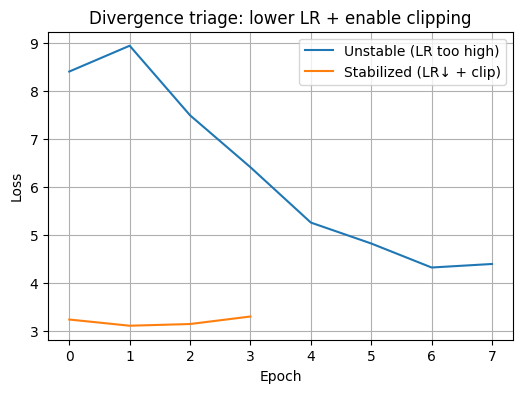

In [15]:

# Simulate "too high LR" and then reduce it with clipping
bad_cfg = dict(seed=42, epochs=8, lr=1e-1, dropout=0.0, weight_decay=0.0, label_smoothing=0.0, patience=2, clip_grad=None)
_, bad_log = train_run(bad_cfg)

fix_cfg = dict(seed=42, epochs=8, lr=5e-3, dropout=0.0, weight_decay=0.0, label_smoothing=0.0, patience=2, clip_grad=1.0)
_, fix_log = train_run(fix_cfg)

plt.figure()
plt.plot([h['val_loss'] for h in bad_log['history']], label="Unstable (LR too high)")
plt.plot([h['val_loss'] for h in fix_log['history']], label="Stabilized (LR↓ + clip)")
plt.title("Divergence triage: lower LR + enable clipping")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()



## 14) Minimal Run Log (Compare Apples-to-Apples)
Capture config + summary metrics in a tiny dict for each run.


In [16]:

def summarize(log):
    best = min(h['val_loss'] for h in log['history'])
    last = log['history'][-1]['val_loss']
    return {'best_val_loss': best, 'last_val_loss': last, 'epochs_run': len(log['history'])}

summary_table = []
for name, lg in [('baseline', base_log), ('dropout', drop_log), ('starter', starter_log)]:
    row = {'run': name}; row.update(base_log['config'] if name=='baseline' else lg['config']); row.update(summarize(lg))
    summary_table.append(row)

for r in summary_table:
    keys = ['run','dropout','weight_decay','label_smoothing','patience','best_val_loss','epochs_run']
    print({k:r.get(k) for k in keys})


{'run': 'baseline', 'dropout': 0.0, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'patience': 3, 'best_val_loss': 3.05961012840271, 'epochs_run': 7}
{'run': 'dropout', 'dropout': 0.1, 'weight_decay': 0.0, 'label_smoothing': 0.0, 'patience': 3, 'best_val_loss': 3.0824484825134277, 'epochs_run': 6}
{'run': 'starter', 'dropout': 0.1, 'weight_decay': 0.01, 'label_smoothing': 0.05, 'patience': 3, 'best_val_loss': 3.1181111335754395, 'epochs_run': 6}



---

### Notes
- Keep batches small on low-memory machines. Reduce `EPOCHS` if runtime is long.
- The toy dataset is intentionally tiny; real gains will be larger on real corpora.
- Use the same one-change-then-measure discipline on your projects.
